development of a common function to calculate the ROI of straight forward strategiers.
Here if we bet on the player with the **better elo** and a **better ATP-rank** depending on the minimum difference  of these values.


In [109]:
import os
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

import pandas as pd
from datetime import datetime,timedelta


os.chdir('Python')
from eda_functions import *
from utilities import *
os.chdir('../')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [6]:
data = load("Generated Data/atp_data")

In [63]:
beg_year = 2005
dat = data[(data.Date.dt.year >= beg_year)]
dat.dropna(inplace = True)

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
dat['elo_diff'] = dat.elo_winner - dat.elo_loser
dat['rank_diff'] = dat.LRank - dat.WRank
dat['smaller_ps'] = dat[['PSL','PSW']].min(axis=1)
dat['smaller_b365'] = dat[['B365W','B365L']].min(axis=1)

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

# Final function

In [107]:
def gain_better(
        data, 
        elo_diff = 0, 
        rank_diff = 0, 
        threshold = None, 
        tax = 0.0, 
        round_ = None, 
        limit = 200, 
        verbose=1, 
        data_back = 0,
        rst_idx = 1):
    '''
    Gives back the avarage performace of betting. Staight betting on the 
        player with the better elo-score AND the better Rank.
    
    data: the given DataFrame.
    
    tax: tax rate to be considered directly on the wager.
    
    round_: index of list. selecting the round to be inspected. If None then 
        all rounds are considered.
        ['1st Round', '2nd Round','3rd Round', '4th Round', 'Quarterfinals', 
        'Semifinals', 'The Final']
        
    limit: maximum odds to be considered
    
    thr: minimum odd as theshold for betting. If 'None' then threshold 
        calculated by tax if set.
        
    diff_elo: how much higher should the elo-score at least be.
    diff_rank: how much higher should the rank at least be
    verbose: if verbose is 1 summary is printed out
    
    
    data_back: if 1 a dataframe with the affected matches will be returned 
        including the rolling gain.
        
    rst_idx: if 1 the index of the returned dataframe is reset. 
        Else the indices remain as in the initial given data 
        (only needed if data_back = 1)
    '''
    
    # calculate the thershold according the tax if no threshold is given. 
    # Will be 1.0 id tax is 0.0
    thr = 1/(1-tax) if threshold == None else threshold
    
    rounds = pd.Series(['1st Round', '2nd Round','3rd Round', '4th Round', 
                        'Quarterfinals', 'Semifinals', 'The Final'])
    
    round_x = None if round_ == None else list([round_]) \
        if type(round_) == int else round_
    
    rnd = list(rounds) if round_x == None else list(rounds[round_x])
    
    dat = data[(data.Round.isin(rnd))]

    elo = elo_diff
    rk = rank_diff
    
    # selecting won bets 
    won = dat[(dat.elo_diff > elo) & (dat.rank_diff > rk) & \
              (dat.B365W >= thr) & (dat.B365W <= limit)]
    
    # amount of failed bets            
    lost = dat[(dat.elo_diff < -elo) & (dat.rank_diff < -rk) & \
               (dat.B365L >= thr) & (dat.B365L <= limit)]
    
    # How much got back
    cashback = won.B365W.sum()
    
    # invested
    invest = won.shape[0] + lost.shape[0]
    
    # ROI absolute
    gain = cashback - invest
    
    # ROI percentage
    ROI_perc = round((cashback/invest)*100,2)
    
    # ROI performance
    ROI_perf = round((gain/invest)*100,2)
    
    #results = [invest, ROI_perf, ]
    
    if verbose:
        print(f'Investment:         {invest}     (Number of matches)')
        print(f'Amount of return:   {round(cashback,2)}')
        print(f'Gain:               {round(gain,2)}')
        print(f'Percentage of ROI:  {ROI_perc} %')
        print(f'Performance of ROI: {ROI_perf} %')
    
    if data_back:
        won['gain'] = won.B365W - 1
        lost['gain'] = -1
        result_df = pd.concat([won, lost])
        result_df.sort_values(by=['Date'], inplace=True, ascending=True)
        result_df['rolling_gain'] = result_df.gain.cumsum()
        
        if rst_idx:
            #result_df.reset_index(drop=True)
            result_df.reset_index(inplace=True)
    
        return result_df
    
    
    #return k, k1, (k1 + k2), g
    #return k

## Some output

In [108]:
gain_better(dat, 
            elo_diff = 125, 
            rank_diff = 100, 
            threshold = None, 
            tax = 0.0, 
            round_ = 0, 
            limit = 2000, 
            verbose=1)

Investment:         1963     (Number of matches)
Amount of return:   1852.21
Gain:               -110.79
Percentage of ROI:  94.36 %
Performance of ROI: -5.64 %


In [110]:
dat_21 = gain_better(dat, 
            elo_diff = 125, 
            rank_diff = 100,
            round_ = 0, 
            verbose=1,
            data_back = 1)

Investment:         1963     (Number of matches)
Amount of return:   1852.21
Gain:               -110.79
Percentage of ROI:  94.36 %
Performance of ROI: -5.64 %


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Previous attempts and trash

The following *gain_better_ini()* was the initial reference found that worked and I was sure that I get what I desired. 

But due to the many *.iloc[i]s* and appending lists the function was very slow, but due to its goal it's the function to control if the function above gives at least the right ROI.


In [95]:
#df_new = dat[dat.Round == '1st Round']
def gain_better_ini(dat, elo_diff = 0, rank_diff = 0, threshold = None, tax = 0.0, round_ = None, limit = 200, verbose=1):

    # calculate the thershold according the tax if no threshold is given. Will be 1.0 id tax is 0.0
    thr = 1/(1-tax) if threshold == None else threshold
    
    rounds = pd.Series(['1st Round', '2nd Round','3rd Round', '4th Round', 'Quarterfinals', 'Semifinals', 'The Final'])
    
    round_x = None if round_ == None else list([round_]) if type(round_) == int else round_
    rnd = list(rounds) if round_x == None else list(rounds[round_x])
    
    df_new = dat[(dat.Round.isin(rnd))]

    #df_new = dat
    iis_p =[]
    iis_n =[]
    gain = 0
    gain_list =[0]
    elo = elo_diff
    rk = rank_diff

    for i in range(df_new.shape[0]):
        d = df_new.iloc[i].elo_diff
        dr = df_new.iloc[i].rank_diff
        oddW = df_new.iloc[i].B365W
        oddL = df_new.iloc[i].B365L
        if d > (elo) and dr > rk and oddW >= thr and oddW <= limit:
            gain +=  (df_new.iloc[i].B365W-1)
            gain_list.append(gain)
            iis_p.append(i)
        elif d < (-elo) and dr < (-rk) and oddL >= thr and oddL <= limit:
            gain -= 1
            gain_list.append(gain)
            iis_n.append(i)
        else:
            pass
    
    if verbose:
        print(f'Number of matches: {len(gain_list)}')
        print(f'Amount of return:  {gain}')
        print(f'Percentage of ROI: {((gain+len(gain_list))/len(gain_list))*100} %')
        print(f'Percentage of ROI: {((gain)/len(gain_list))*100} %')
    
    return gainlist

In [96]:
gain_better_ini(dat, 
            elo_diff = 125, 
            rank_diff = 100, 
            threshold = None, 
            tax = 0.0, 
            round_ = 0, 
            limit = 2000, 
            verbose=1)

Number of matches: 1964
Amount of return:  -110.79300000000015
Percentage of ROI: 94.35880855397149 %
Percentage of ROI: -5.641191446028521 %


In [103]:
gain_better(dat, 
            elo_diff = 125, 
            rank_diff = 100, 
            threshold = None, 
            tax = 0.0, 
            round_ = 0, 
            limit = 2000, 
            verbose=1)

Number of matches:  1963
Amount of return:   1852.21
Gain:               -110.79
Percentage of ROI:  94.36 %
Performance of ROI: -5.64 %


In [65]:
gain_perc_b365(dat, 
            elo_diff = 125, 
            rank_diff = 100, 
            threshold = None, 
            tax = 0.0, 
            round_ = 0, 
            limit = 2000, 
            verbose=1)

Number of matches:  1963
Amount of return:   1852.2069999999999
Gain:               -110.79300000000012
Percentage of ROI:  94.35593479368313 %
Performance of ROI: -5.644065206316868 %


In [28]:
#df_new = dat[dat.Round == '1st Round']
def gain_better(dat, elo_diff = 0, rank_diff = 0, threshold = None, tax = 0.0, round_ = None, limit = 200, verbose=1):

    # calculate the thershold according the tax if no threshold is given. Will be 1.0 id tax is 0.0
    thr = 1/(1-tax) if threshold == None else threshold
    
    rounds = pd.Series(['1st Round', '2nd Round','3rd Round', '4th Round', 'Quarterfinals', 'Semifinals', 'The Final'])
    
    round_x = None if round_ == None else list([round_]) if type(round_) == int else round_
    rnd = list(rounds) if round_x == None else list(rounds[round_x])
    
    df_new = dat[(dat.Round.isin(rnd))]

    #df_new = dat
    iis_p =[]
    iis_n =[]
    gain = 0
    gain_list =[0]
    elo = elo_diff
    rk = rank_diff

    for i in range(df_new.shape[0]):
        k = dat[['elo_diff','rank_diff','B365W','B365L']].iloc[i]

        if k.elo_diff > (elo) and k.rank_diff > rk and k.B365W >= thr and k.B365W <= limit:
            gain +=  k.B365W-1
            #gain +=  (df_new.iloc[i].B365W-1)
            gain_list.append(gain)
            iis_p.append(i)
        elif k.elo_diff < (-elo) and k.rank_diff < (-rk) and k.B365L >= thr and k.B365L <= limit:
            gain -= 1
            gain_list.append(gain)
            iis_n.append(i)
        else:
            pass
    
    if verbose:
        print(f'Number of matches: {len(gain_list)}')
        print(f'Amount of return:  {gain}')
        print(f'Percentage of ROI: {((gain+len(gain_list))/len(gain_list))*100} %')
        print(f'Percentage of ROI: {((gain)/len(gain_list))*100} %')
    

In [36]:
#df_new = dat[dat.Round == '1st Round']
def gain_better(dat, elo_diff = 0, rank_diff = 0, threshold = None, tax = 0.0, round_ = None, limit = 200, verbose=1):

    # calculate the thershold according the tax if no threshold is given. Will be 1.0 id tax is 0.0
    thr = 1/(1-tax) if threshold == None else threshold
    
    rounds = pd.Series(['1st Round', '2nd Round','3rd Round', '4th Round', 'Quarterfinals', 'Semifinals', 'The Final'])
    
    round_x = None if round_ == None else list([round_]) if type(round_) == int else round_
    rnd = list(rounds) if round_x == None else list(rounds[round_x])
    
    df_new = dat[(dat.Round.isin(rnd))]

    #df_new = dat
    iis_p =[]
    iis_n =[]
    gain = 0
    gain_list =[0]
    elo = elo_diff
    rk = rank_diff

    for i in range(df_new.shape[0]):
        k = df_new[['elo_diff','rank_diff','B365W','B365L']].iloc[i]
        d = k.elo_diff
        dr = k.rank_diff
        oddW = k.B365W
        oddL = k.B365L
        #d = df_new.iloc[i].elo_diff
        #dr = df_new.iloc[i].rank_diff
        #oddW = df_new.iloc[i].B365W
        #oddL = df_new.iloc[i].B365L
        if d > (elo) and dr > rk and oddW >= thr and oddW <= limit:
            gain +=  (oddW-1)
            gain_list.append(gain)
            iis_p.append(i)
        elif d < (-elo) and dr < (-rk) and oddL >= thr and oddL <= limit:
            gain -= 1
            gain_list.append(gain)
            iis_n.append(i)
        else:
            pass
    
    if verbose:
        print(f'Number of matches: {len(gain_list)}')
        print(f'Amount of return:  {gain}')
        print(f'Percentage of ROI: {((gain+len(gain_list))/len(gain_list))*100} %')
        print(f'Percentage of ROI: {((gain)/len(gain_list))*100} %')
    

In [40]:
#df_new = dat[dat.Round == '1st Round']
def gain_better(dat, elo_diff = 0, rank_diff = 0, threshold = None, tax = 0.0, round_ = None, limit = 200, verbose=1):

    # calculate the thershold according the tax if no threshold is given. Will be 1.0 id tax is 0.0
    thr = 1/(1-tax) if threshold == None else threshold
    
    rounds = pd.Series(['1st Round', '2nd Round','3rd Round', '4th Round', 'Quarterfinals', 'Semifinals', 'The Final'])
    
    round_x = None if round_ == None else list([round_]) if type(round_) == int else round_
    rnd = list(rounds) if round_x == None else list(rounds[round_x])
    
    df_new = dat[(dat.Round.isin(rnd))]

    #df_new = dat
    iis_p =[]
    iis_n =[]
    gain = 0
    gain_list =[0]
    elo = elo_diff
    rk = rank_diff
    counter = 0

    for i in range(df_new.shape[0]):
        d = df_new.iloc[i].elo_diff
        dr = df_new.iloc[i].rank_diff
        oddW = df_new.iloc[i].B365W
        oddL = df_new.iloc[i].B365L
        if d > (elo) and dr > rk and oddW >= thr and oddW <= limit:
            gain +=  (df_new.iloc[i].B365W-1)
            counter += 1
            #gain_list.append(gain)
            #iis_p.append(i)
        elif d < (-elo) and dr < (-rk) and oddL >= thr and oddL <= limit:
            gain -= 1
            counter += 1
            #gain_list.append(gain)
            #iis_n.append(i)
        else:
            pass
    
    if verbose:
        print(f'Number of matches: {counter}')
        print(f'Amount of return:  {gain}')
        print(f'Percentage of ROI: {((gain+counter)/counter)*100} %')
        print(f'Percentage of ROI: {((gain)/counter)*100} %')
    

In [72]:
def gain_perc_b365(data, elo_diff = 0, rank_diff = 0, threshold = None, tax = 0.0, round_ = None, limit = 200, verbose=1, data_back = 0):
    '''
    Gives back the avarage performace of betting. Staight betting on the player with the better elo-score AND the better Rank.
    
    dat: the given DataFrame.
    tax: tax rate to be considered directly on the wager.
    round_: index of list. selecting the round to be inspected. If None then all rounds are considered.
    ['1st Round', '2nd Round','3rd Round', '4th Round', 'Quarterfinals', 'Semifinals', 'The Final']
    limit: maximum odds to be considered
    thr: minimum odd as theshold for betting. If 'None' then threshold calculated by tax if set.
    diff_elo: how much higher should the elo-score at least be.
    diff_rank: how much higher should the rank at least be
    
    return:
    gain: average performance
    (n_bets: number of bets)
    (n_good_bets: number of sucessful bets)
    '''
    # calculate the thershold according the tax if no threshold is given. Will be 1.0 id tax is 0.0
    thr = 1/(1-tax) if threshold == None else threshold
    
    rounds = pd.Series(['1st Round', '2nd Round','3rd Round', '4th Round', 'Quarterfinals', 'Semifinals', 'The Final'])
    
    round_x = None if round_ == None else list([round_]) if type(round_) == int else round_
    rnd = list(rounds) if round_x == None else list(rounds[round_x])
    
    dat = data[(data.Round.isin(rnd))]

    elo = elo_diff
    rk = rank_diff
    
    # selecting won bets 
    won = dat[(dat.elo_diff > elo) & (dat.rank_diff > rk) & (dat.B365W >= thr) & (dat.B365W <= limit)]
    
    # amount of failed bets            
    lost = dat[(dat.elo_diff < -elo) & (dat.rank_diff < -rk) & (dat.B365L >= thr) & (dat.B365L <= limit)]
    
    # How much got back
    cashback = won.B365W.sum()
    
    # invested
    invest = won.shape[0] + lost.shape[0]
    
    # ROI absolute
    gain = cashback - invest
    
    # ROI percentage
    ROI_perc = (cashback/invest)*100
    
    # ROI performance
    ROI_perf = (gain/invest)*100
    
    if verbose:
        print(f'Number of matches:  {invest}')
        print(f'Amount of return:   {cashback}')
        print(f'Gain:               {gain}')
        print(f'Percentage of ROI:  {ROI_perc} %')
        print(f'Performance of ROI: {ROI_perf} %')
    
    if data_back:
        won['gain'] = won.B365W - 1
        lost['gain'] = -1
        result = pd.concat([won, lost])
        result.sort_values(by=['Date'], inplace=True, ascending=True)
        result['rolling_gain'] = result.gain.cumsum()
    
        return result
    
    
    #return k, k1, (k1 + k2), g
    #return k

In [52]:
gain_perc_b365(dat, 
            elo_diff = 125, 
            rank_diff = 100, 
            threshold = None, 
            tax = 0.0, 
            round_ = 0, 
            limit = 2000, 
            verbose=1)

Number of matches:  2142
Amount of return:   2027.7289999999998
Gain:               -114.27100000000019
Percentage of ROI:  94.66521942110177 %
Performance of ROI: -5.3347805788982345 %


In [90]:
dat_27 = gain_better(dat, 
            elo_diff = 125, 
            rank_diff = 100, 
            threshold = None, 
            tax = 0.0, 
            round_ = 0, 
            limit = 2000, 
            verbose=1,
            data_back = 1)

Number of matches:  1963
Amount of return:   1852.2069999999999
Gain:               -110.79300000000012
Percentage of ROI:  94.35593479368313 %
Performance of ROI: -5.644065206316868 %


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [91]:
dat_27.head()

,index,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,...,B365L,elo_winner,elo_loser,proba_elo,elo_diff,rank_diff,smaller_ps,smaller_b365,gain,rolling_gain
0,14539,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,...,3.250,1671.455867,1476.355300,0.754561,195.100567,271,1.305,1.286,0.286,0.286
1,14550,3,Doha,Qatar Exxon Mobil Open,2005-01-04,International,Outdoor,Hard,1st Round,3,...,1.167,1476.804624,1663.865788,0.254110,-187.061164,-124,1.222,1.167,-1.000,-0.714
2,14564,1,Adelaide,Next Generation Hardcourts,2005-01-04,International,Outdoor,Hard,1st Round,3,...,5.000,1956.470696,1552.944195,0.910755,403.526501,103,1.111,1.143,0.143,-0.571
3,14546,3,Doha,Qatar Exxon Mobil Open,2005-01-04,International,Outdoor,Hard,1st Round,3,...,1.533,1534.047184,1698.406710,0.279664,-164.359526,-229,1.877,1.533,-1.000,-1.571
4,14543,2,Chennai,TATA Open,2005-01-04,International,Outdoor,Hard,1st Round,3,...,6.500,1810.218031,1404.477376,0.911785,405.740655,252,1.092,1.100,0.100,-1.471


In [77]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

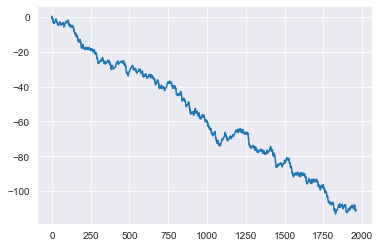

In [92]:
#plt.plot(dat_27.Date,dat_27.rolling_gain)
plt.plot(dat_27.rolling_gain)

In [61]:
g1 = np.ones(dat2.shape[0])
#dat2['gain'] = g1
#dat2['gain'] = dat2.apply(lambda row: 1, axis = 1)
dat2['gain'].iloc[:] = dat2.B365W -1
#dat2['gain'].iloc[:] = -1

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [62]:
dat2.gain

14518    1.870
14519    0.533
14520    0.364
14521    0.533
14522    0.444
14523    0.300
14524    0.400
14525      NaN
14526    0.286
14527      NaN
14528    0.030
14529    1.875
14530    1.100
14531      NaN
14532    2.250
14533    1.000
14534    0.800
14535    0.615
14536    0.333
14537    0.667
14538    0.833
14539    0.286
14540    0.063
14541    2.250
14542    0.533
14543    0.100
14544    0.140
14545      NaN
14546    1.375
14547    0.400
         ...  
54878    0.250
54879    0.250
54880    1.750
54881    1.370
54882    0.100
54883    0.570
54884    0.570
54885    1.100
54886    0.250
54887    0.300
54888    0.720
54889    0.160
54890    4.000
54891    0.120
54892    0.120
54893    0.120
54894    2.750
54895    2.000
54896    2.000
54897    4.000
54898    0.160
54899    1.100
54900    1.000
54901    2.200
54902    2.200
54903    0.440
54904    0.900
54905    2.500
54906    0.800
54907    1.000
Name: gain, Length: 40390, dtype: float64